### A larger-scale VAR(1) application of the BEGRS methodology

So now we scale up. To keep things comparable, we'll keep exactly the same framework as the previous notebook, where we estimate a simple VAR(1):

$$\mathbf{y}_t = \mathbf{A}\mathbf{y}_{t-1} + \mathbf{\epsilon}_t \qquad \mathbf{\epsilon}_t \sim N(0, \Sigma)$$

This keeps the imports/functions simple as it is the same as before. The difference now is that there will be 4 observables in $\mathbf{y}$, and we will attempt to estimate all 16 parameters of the resulting $4 \times 4$ matrix of parameters $\mathbf{A}$, using 200 observations of data. The scale of this problem is similar to that faced in a medium size ABM estimation: 16 parameter to estimate, 4 observable variables.

**Note:** As for the Brock & Hommes example we saw earlier, this notebook takes a while to run, so it's not advisable to re-run it within the workshop. This is the main reason why I instead provided a simpler example!

In [1]:
import time
import sobol
import math

import numpy as np
from begrs import begrs
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from workshopFunctions import VAR, formatTableText
from statsmodels.iolib.table import SimpleTable

#%% --------------------------------------------------------------------------
# Declare any extra functions

def getSobolSamples(numSamples, parameterSupport, skips):
    """
    Draw sobol samples out of a parameter space

    Parameters
    ----------
    numSamples : INT
        Number of samples to draw from the sequence.
    parameterSupport : numpy 2D array of floats
        Bounds for the parameter values.
    skips : INT
        Number of initial draws to skip (i.e. start deeper in the sequence).

    Returns
    -------
    sobol_samples : numpy 2D array of floats
        Draws from the Sobol sequence.

    """
    params = np.transpose(parameterSupport)
    sobol_samples = params[0,:] + sobol.sample(
                        dimension = parameterSupport.shape[0], 
                        n_points = numSamples, 
                        skip = skips
                        )*(params[1,:]-params[0,:])
    
    return sobol_samples

def logP(sample):
    """
    Example of posterior function, using the BEGRS soft flat prior
    Any prior can be used, but needs to produce both the log prior and its
    gradient.    

    Parameters
    ----------
    sample : numpy 1D array of floats
        input parameter values.

    Returns
    -------
    float
        log posterior at the sample point.
    numpy 1D array of floats
        gradient of the log posterior at the input parameter values.

    """
     
    prior = begrsEst.softLogPrior(sample) 
    logL = begrsEst.logP(sample)

    return (prior[0] + logL[0], prior[1] + logL[1])

As always, lets start by simulating our training and testing data sets. A few things to note:
- We 'only' draw 1000 samples from the parameter space. This may seem like a lot, but remember that this is now **16-dimensional**, so the density of points in this space is going to be *very* low!
- We generate 100 Monte Carlo replications of the VAR for the testing parameter values, so that we can better evaluate the performance of BEGRS.
- We draw all parameters (training/testing) from a 16-dimensional Sobol sequence. Drawing the testing parameters from further down the same sequence as the training data ensures that the testing parameter is not 'close' to any given training point.
- All parameters are bounded in $[-0.7,0.7]$. This is to avoid problems with explosive roots, although we additional check the stability of each parameter draw and discard them if unstable.
- We aren't estimating the parameters of the noise matrix. This is because in the GP framework, noise is accounted for in a different way, and is not a parameter of interest.

In [2]:
# Generate low-discrepancy training samples
# Specify parameters
numVars = 4
numParams = numVars**2
numSamples = 1000
skip = 500
bufferRatio = 1.5
parameter_range = np.array([(-0.7, 0.7)]*numParams)
N = 200
burn = 50
numIter = 1000

# Draw from a Sobol sequence, checking VAR stability
samples_raw = getSobolSamples(int(numSamples*bufferRatio), 
                                parameter_range,skip)

samplesEigen = []
samples = []
MaxL_norms = []

for count, sample in enumerate(samples_raw):
    A = np.asmatrix(
            np.reshape(sample, (numVars,numVars))
        )

    L,U = np.linalg.eig(A)
    L_norm = np.absolute(L) 
    
    if max(L_norm) < 1:
        samplesEigen.append(L)
        samples.append(sample)
        MaxL_norms.append(max(L_norm))
    
    if len(samples) == numSamples:
        samplesEigen = np.asarray(samplesEigen)
        samples = np.asarray(samples)
        break

print('Training data:')
print(' {:d} draws required for {:d} samples'.format(count+1,numSamples))

# Simulate VAR training data
Scorr = 0.25            # Set correlation to a moderate level
C = np.asmatrix(np.zeros((numVars,1)))
S = (Scorr*np.asmatrix(np.ones(numVars)) 
     + (1-Scorr)*np.asmatrix(np.identity(numVars)))

trainData = np.zeros([N,numVars,numSamples])
for i,sample in enumerate(samples):
    A = np.asmatrix(
            np.reshape(sample, (numVars,numVars))
        )
    VARsim = VAR(C,A,S)
    trainData[:,:,i] = VARsim.simulate(N,burn,rep=i).transpose()

# Simulate 'emprirical' testing samples
samplesRawEmp = getSobolSamples(10, 
                                parameter_range,
                                skip + int(numSamples*bufferRatio))

for count, sample in enumerate(samplesRawEmp):
    A = np.asmatrix(
            np.reshape(sample, (numVars,numVars))
        )

    L,U = np.linalg.eig(A)
    L_norm = np.absolute(L) 
    
    if max(L_norm) < 1:
        sampleEmp = sample
        break
    
print('Testing data:')
print(' Number of draws used: {:d}'.format(count+1))

# Simulate VAR testing data 
A = np.asmatrix(
       np.reshape(sample, (numVars,numVars))
   )

numTest = 100
testData = np.zeros([N,numVars,numTest])

for i in range(numTest):
    VARsim = VAR(C,A,S)
    testData[:,:,i] = VARsim.simulate(N,burn, rep = i).transpose()

Training data:
 1233 draws required for 1000 samples
Testing data:
 Number of draws used: 1


The reason we check for stability is we don't want to be simulating explosive models, these would certainly throw the GP off. Generally, the draws are pretty stable, as we are only throwing away 23% of the raw draws from the Sobol sequence.

Let's plot one of the MC replications the testing data as well as the eigenvalue plot for the training/testing parameter draws.

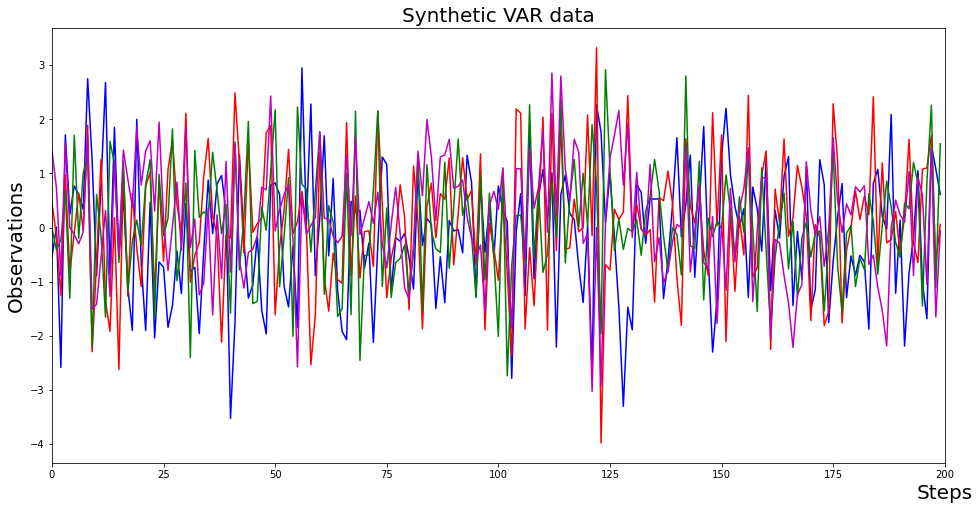

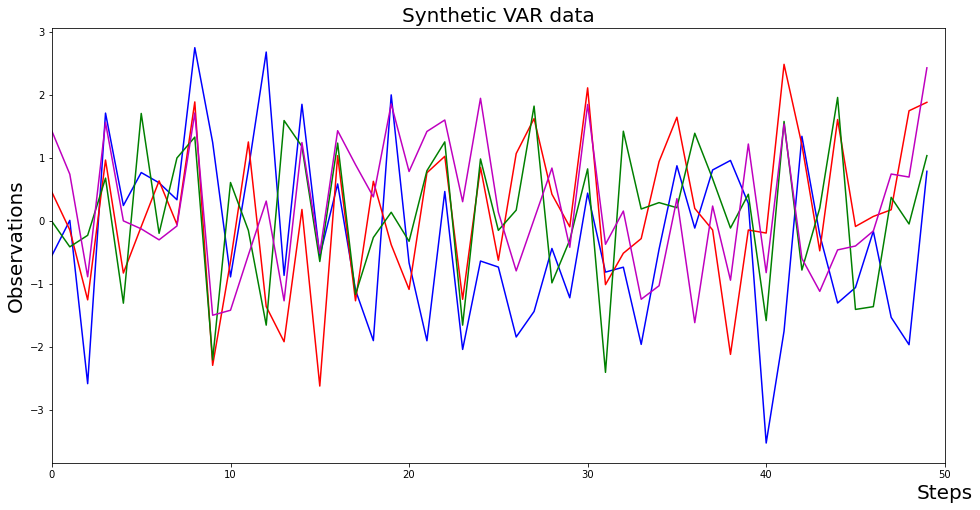

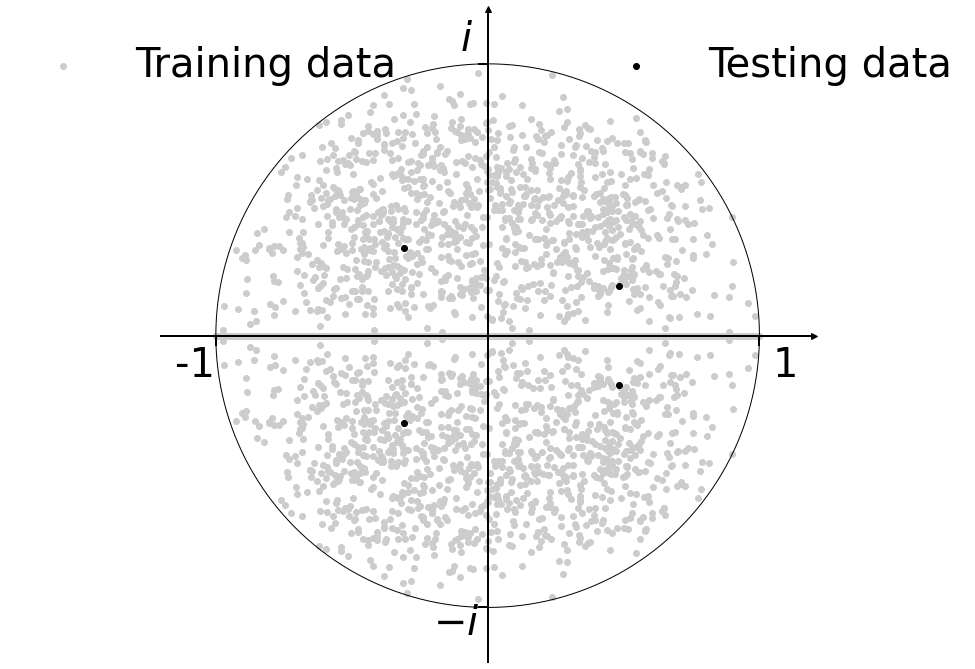

In [3]:
# Plot the first dataset
fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(N), testData[:,0,0], color = 'b')
ax.plot(np.arange(N), testData[:,1,0], color = 'r')
ax.plot(np.arange(N), testData[:,2,0], color = 'g')
ax.plot(np.arange(N), testData[:,3,0], color = 'm')
ax.set_xlim(0,N)
ax.set_xlabel(r'Steps', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'Observations', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('Synthetic VAR data', fontdict = {'fontsize': 20});

# Plot the first dataset - just the first 50 observations
fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(50), testData[0:50,0,0], color = 'b')
ax.plot(np.arange(50), testData[0:50,1,0], color = 'r')
ax.plot(np.arange(50), testData[0:50,2,0], color = 'g')
ax.plot(np.arange(50), testData[0:50,3,0], color = 'm')
ax.set_xlim(0,50)
ax.set_xlabel(r'Steps', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'Observations', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('Synthetic VAR data', fontdict = {'fontsize': 20});

# Plot eigenvalues to ilustrate coverage of the dynamics
fontSize = 40
ax_min = -1.2
ax_max = 1.2

pi_vec = np.arange(0,2*math.pi,(2*math.pi)/1000)
eigs = samplesEigen.flatten()

fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.cos(pi_vec),np.sin(pi_vec),'k', linewidth=1)
ax.scatter(np.real(eigs), np.imag(eigs), color = [0.8, 0.8, 0.8], 
           label = 'Training data')
ax.scatter(np.real(L), np.imag(L), c='k',
           label = 'Testing data')
ax.legend(loc='upper center', frameon=False, ncol = 2, columnspacing = 5, 
          prop={'size':fontSize})
ax.set_ylim(top = ax_max, bottom = ax_min)
ax.set_xlim(left = ax_min,right = ax_max)
ax.plot(ax_max, 0, ">k", clip_on=False)
ax.plot(0, ax_max, "^k", clip_on=False)
ax.set_aspect('equal', 'box')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_position('zero')
ax.set_xticks([-1,1])
ax.set_xticklabels(['',''])
ax.set_yticks([-1,1])
ax.set_yticklabels(['',''])
ax.xaxis.set_tick_params(length = 10, width = 2)
ax.yaxis.set_tick_params(length = 10, width = 2)
ax.annotate('1', xy=(1.05, -0.1), xytext=(1.05, -0.15), 
            size = fontSize)
ax.annotate('-1', xy=(-1.1, -0.1), xytext=(-1.15, -0.15), 
            size = fontSize)
ax.annotate('$i$', xy=(-0.1, 1.05), xytext=(-0.1, 1.05), 
            size = fontSize)
ax.annotate('$-i$', xy=(-0.15, -1.1), xytext=(-0.2, -1.1), 
            size = fontSize);

The VAR plots look like a mess. Good luck 'eyeyballing' the dynamics from the plots... I thought it might look prettier, but at least it does effectively convey the challenge in pinning down the 16 parameters of interest from what seems to just be a jumble of lines.

The Eigenvalue plot , however, provides an very effective way of showing the coverage of the parameter space (rather than trying to picture the underlying 16 dimensions of the parameter space).

#### Training the BEGRS surrogate

Let's now train the surrogate. Regarding the settings of the hyper paramters:
- The number of observables is still low enough (4) that we can set one latent per variable
- We pick 1000 inducing points. This is a bit arbitrary, but sensitivity analyses show that 500 is starting to be too little, so to be safe we double it to 100, which is enough. Remember that is is better to be over then under, as there is no penalty to having more, other than the computational cost.
- 50 iterations is enough here (trial and error...)
- We have 200,000 training observations here, so we now need to cut the training data into batches, and we set 5,000 as a relatively 'fast' option. It also works for 10,000 so this parameter is not that critical.
- The learning rate must be reduced, down to 0.05 here. Again, with 200,000 observations cut up into 40 batches of 5,000 each, we need to ensure that updating is slow enough that the algorithm gets to see all the batches before the surrogate converges.

In [4]:
# Train the surrogate on the VAR data

# Set the hyper parameters
num_latents = 4         # 4 here, but in general can be identified by pca
num_inducing_pts = 1000 # Subset of 'non-sparse' inputs - 500 or 1000
numiter = 50            # Number of epoch iterations (50 is usually OK)
batchSize = 5000        # Size of training minibatches (mainly a speed issue)
learning_rate = 0.05    # Learning rate (0.05 is good when minibatches are used)

# Create a begrs estimation object, train on simulated data
t_start = time.time()
begrsEst = begrs()
begrsEst.setTrainingData(trainData, samples, parameter_range)
begrsEst.train(num_latents, num_inducing_pts, batchSize, numiter, 
                learning_rate)
print(' Training time: {:10.4f} secs.'.format(time.time() - t_start))

# Let's save it to make sure the time cost isn't wasted...
begrsEst.save('begrsVAR')

───────────────────────────────────────────────────────────────────────────
 Setting training data set - Done
 - Normalised variables (0 mean, 1 std. dev.)

 N° of parameters:    16
 N° of variables:     4
 N° of parameter samples:  1000
───────────────────────────────────────────────────────────────────────────
 Training gaussian surrogate model
 CUDA not available - Using CPU
Iteration 50 : 100%|████████████████████████████████████████████████████████| 40/40 [02:47<00:00,  4.20s/it, loss=2.94]
 Training time:  9099.6073 secs.
───────────────────────────────────────────────────────────────────────────
 Saving model to: begrsVAR  - Done


This does take quite a bit of time (~2.5 hours), but note that this is because we're using the CPU. Because the GP surrogate is run using the `GPytorch` package, which itself is written using `torch`, the code runs much faster on a GPU. By default, BEGRS is designed to automatically search for a GPU device and use that, only picking the CPU if there is no GPU available. Of course, this can be overridden.

#### Estimating parameters on the test data

Let's now run a Monte Carlo on the posterior mode, to see if BEGRS can reliably identify the 16 parameters that make up the matrix of lags for the VAR.

In [5]:
# Estimate on the testing VAR data

negLogLik = lambda *args: tuple( -i for i in logP(*args))

init = np.zeros(numParams)
bounds = numParams*[(-3**0.5,3**0.5)]
estimatesBegrs = []
estimatesTrue = []
total_time_start = time.time()
for empInd in range(numTest):

    # Get  'empirical'  data, set it as the BEGRS testing set
    xEmp = testData[:,:,empInd]
    print('Empirical setting: {:d}'.format(empInd))
    
    begrsEst.setTestingData(xEmp)
    
    # Find posterior mode
    print('Finding MAP vector')
    t_start = time.time()

    sampleMAP = minimize(negLogLik, init, method='L-BFGS-B',
                          bounds = bounds, jac = True)

    rawEst = sampleMAP.x
    estimatesBegrs.append(begrsEst.uncenter(rawEst))
    print('BEGRS estim. time: {:10.4f} secs.'.format(time.time() - t_start))
    
    # Let's also get the MLE estimate for the , for comparison
    negLogLikTrue = lambda vec: -VARsim.likelihood(xEmp.transpose(),
                                                   A=np.asmatrix(
                                                       np.reshape(vec, 
                                                                  (numVars,
                                                                   numVars))
                                                                   )
                                                    )
    print('Finding Maximum likelihood vector')
    t_start = time.time()
    maximumLikelihoodVAR = minimize(negLogLikTrue, 
                              init,
                              method='BFGS', 
                              options={'gtol':1e-4})
    print('Max. Likelihood time: {:10.4f} secs.\n'.format(time.time() - t_start))
    estimatesTrue.append(maximumLikelihoodVAR.x)
    
print('\n Total time: {:10.4f} secs.'.format(time.time() - total_time_start))

Empirical setting: 0
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    34.4174 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.7961 secs.

Empirical setting: 1
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    36.0612 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.7630 secs.

Empirical setting: 2
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    49.8863 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.7019 secs.

Empirical setting: 3
─────────────────────────────────────────────────────────────────────────

 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    22.0878 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     3.0246 secs.

Empirical setting: 28
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    28.9848 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.8710 secs.

Empirical setting: 29
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    92.4466 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.7231 secs.

Empirical setting: 30
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vec

 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    33.3168 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.8334 secs.

Empirical setting: 82
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    42.7938 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.7884 secs.

Empirical setting: 83
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS estim. time:    25.9825 secs.
Finding Maximum likelihood vector
Max. Likelihood time:     2.5763 secs.

Empirical setting: 84
───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vec

That took a little while because we ran this over the 100 MC replications, but note that it's not too bad for a single empirical dataset, on the order of a minute here. And as was the case for the training, this will run a lot faster on a GPU. This outlines, however, that even if you do not have access to a high-powered GPU, it remains feasible to use a standard desktop CPU to both train the surrogate and find the mode of the posterior. The kind of MC analysis run here can be parallelised without too many problems as well.

Let's look at the results. Because we gathered both the BEGRS estimation and the MLE

In [6]:
# Let's pick a random test series, see how we do compared to the truth and MLE
ind = 53
paramStrs = [r'A_{1,1}',
             r'A_{1,2}',
             r'A_{1,3}',
             r'A_{1,4}',
             r'A_{2,1}',
             r'A_{2,2}',
             r'A_{2,3}',
             r'A_{2,4}',
             r'A_{3,1}',
             r'A_{3,2}',
             r'A_{3,3}',
             r'A_{3,4}',
             r'A_{4,1}',
             r'A_{4,2}',
             r'A_{4,3}',
             r'A_{4,4}']

parameterValuesSingle = np.concatenate(
                            (sampleEmp[:,None],
                             estimatesBegrs[ind][:,None],
                             estimatesTrue[ind][:,None],
                             ),
                                  axis=1)    

table = SimpleTable(
        formatTableText(parameterValuesSingle,'{:8.3f}'),
        stubs=paramStrs,
        headers=['True','BEGRS', 'MLE'],
        title='Estimation performance, series {:d}'.format(ind),
    )

print(table)
print('\n')

# Now let's look at the average performance over all the test series to see
# if BEGRS deviates statistically from MLE  
estimatesBegrs = np.asarray(estimatesBegrs)
estimatesTrue = np.asarray(estimatesTrue)
    
parameterValues = np.concatenate(
                            (sampleEmp[:,None],
                             np.mean(estimatesBegrs,axis=0)[:,None],
                             np.mean(estimatesTrue,axis=0)[:,None],
                             np.mean(estimatesBegrs - estimatesTrue,
                                     axis=0)[:,None],
                             np.std(estimatesBegrs - estimatesTrue,
                                    axis=0)[:,None]
                             ),
                                  axis=1)    

table = SimpleTable(
        formatTableText(parameterValues,'{:8.3f}'),
        stubs=paramStrs,
        headers=['True','BEGRS', 'MLE', 'mean Delta','std. Delta'],
        title='Estimation performance, average',
    )

print(table)
print('\n')

Estimation performance, series 53 
          True    BEGRS     MLE   
----------------------------------
A_{1,1}    0.154    0.179    0.180
A_{1,2}    0.113    0.153    0.162
A_{1,3}    0.409    0.284    0.322
A_{1,4}   -0.531   -0.518   -0.556
A_{2,1}   -0.496   -0.435   -0.504
A_{2,2}   -0.196   -0.239   -0.251
A_{2,3}    0.081    0.121    0.112
A_{2,4}   -0.065   -0.005   -0.023
A_{3,1}   -0.155   -0.179   -0.129
A_{3,2}   -0.273   -0.279   -0.260
A_{3,3}   -0.068   -0.060   -0.054
A_{3,4}   -0.128   -0.016   -0.003
A_{4,1}   -0.338   -0.302   -0.297
A_{4,2}   -0.597   -0.584   -0.553
A_{4,3}    0.195    0.098    0.122
A_{4,4}    0.459    0.461    0.490
----------------------------------


            Estimation performance, average             
          True    BEGRS     MLE    mean Delta std. Delta
--------------------------------------------------------
A_{1,1}    0.154    0.161    0.159      0.002      0.015
A_{1,2}    0.113    0.093    0.107     -0.014      0.013
A_{1,3}    0.

Even looking at a single replication of the testing data (first table), we can see that the parameters estimated by BEGRS are close to those generated by MLE. Both of these are off by a bit compared to the true parameters, but again remember that we've only got 200 'empirical' observations, so even MLE will struggle to *exactly* hit the true parameter values. 

The MC aggregates, on the other hand, make it very clear that on average MLE and BEGRS are offer equivalent performance in this setting: the average difference in parameter estimates across the 100 replications fall well below the standard errors in most cases. This suggests that any deviations on a given realisation of the empirical data are not significant inj most cases, and only a few parameters show more significant deviations (even if they remain small).

Unlike the simple example, we're not going Bayesian here, because without a GPU it'll take way too long to draw the samples. But this example shows that computationally (a) training and (b) mode-finding is entirely feasible on CPU, so even with relatively limited compute resources, you can still get parameter estimates, even if you can't get the more desirable posterior distribution.

Some issues to flag:
- We have no model uncertainty here. Even if we don't know the true parameter values, we are using the true DGP. Obviously, in a real-life estimation, things will not be as simple, but it is good to know that the methodology can at lest perform well in controlled conditions
- We are in a setting where the observable variables ARE the state variables, so all the information needed for predicting the evolution is available. Again in a real-life case of ABM estimation, this is not going to be the case and might complicate estimation.
- We have not actually looked at an ABM estimation... That's for my conference talk!